<a href="https://colab.research.google.com/github/GustaFTW/TensorFlow-ZTM/blob/main/section8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences of text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2f489557-192b-81b0-c1bb-ef8463b720b0)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-01-30 19:55:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-30 19:55:16 (73.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster os not disaster).

See original source: https://www.kaggle.com/competitions/nlp-getting-started/data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-01-30 19:55:21--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2023-01-30 19:55:22 (70.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python


But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=69)
train_df_shuffled.head()

,id,keyword,location,text,target
421,611,arsonist,[ Blonde Bi Fry. ],'wHeRE's mY aRsOnISt aT???',0
5047,7195,natural%20disaster,home,she's a natural disaster she's the last of the...,0
5046,7194,mudslide,NaN,@nikistitz even the one that looked like a mud...,0
1881,2702,crush,NaN,kenny holland crush da vida,0
6543,9362,survived,NaN,Not one character in the final destination ser...,0


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples?
len(train_df) + len(test_df)

10876

In [ ]:
# Let's visualize some random training examples
import random
number_samples = 3
random_index = random.randint(0, len(train_df)-number_samples)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+number_samples].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday

---

Target: 0 (not real disaster)
Text:
? #nowplaying SONG TO THE SIREN - JOHN FRUSCIANTE (2009) http://t.co/00cY9vXEFF

---

Target: 1 (real disaster)
Text:
Truly a scene of chaos unprecedented in frenzy. Pandemonium even. Utter disorder. That anyone survived such mania is astounding. @catovitch

---



### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation split
                                                                            random_state=69)

In [ ]:
# Check the  lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 examples
train_sentences[:10], train_labels[:10]

(array(['@ChrisDanielShow Nearly-Fatal Pee in San Francisco http://t.co/1tvlFrhm1m',
        "babe I'm gonna ruin you if you let me stay",
        "We're happily collided :)",
        "RT THR 'RT THRArchives: 1928: When Leo the MGM Lion Survived a Plane Crash #TBT http://t.co/Wpkl2qNiQW http://t.co/BD52FxDvhQ'",
        '@FoxNews let me report it to u people instead Mr.Obama just declares CNMI federal disaster area post typhoon soudelor. U guys 2slow2report.',
        "Don't say @ALIPAPER: women got problems this #keepingtheviginaclean thing is very interesting n less expensive #metrofmtalk'",
        "'Jet fuel cant melt steel'\n'The structural failure is illogical'\n'The second plane crashing into the building is fake'\n'It was a bomb'",
        'A grade in Black Horse Famine[MEGA]. Score 0840728\nhttp://t.co/pdiit0AF3Q\n#Dynamix http://t.co/ZQ5KDOx7BY',
        'Even when I was a kid haha super late but folks used to bash me for that shit I understand he survived cancer but he still

## Converting text into numbers

When dealing with a text problem, one of the first trhings you'll have to do before you can build a model is to converty your text to number.

there are a few ways to do this, namely:
* Tokenziation - directo mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
train_sentences[:10]

array(['@ChrisDanielShow Nearly-Fatal Pee in San Francisco http://t.co/1tvlFrhm1m',
       "babe I'm gonna ruin you if you let me stay",
       "We're happily collided :)",
       "RT THR 'RT THRArchives: 1928: When Leo the MGM Lion Survived a Plane Crash #TBT http://t.co/Wpkl2qNiQW http://t.co/BD52FxDvhQ'",
       '@FoxNews let me report it to u people instead Mr.Obama just declares CNMI federal disaster area post typhoon soudelor. U guys 2slow2report.',
       "Don't say @ALIPAPER: women got problems this #keepingtheviginaclean thing is very interesting n less expensive #metrofmtalk'",
       "'Jet fuel cant melt steel'\n'The structural failure is illogical'\n'The second plane crashing into the building is fake'\n'It was a bomb'",
       'A grade in Black Horse Famine[MEGA]. Score 0840728\nhttp://t.co/pdiit0AF3Q\n#Dynamix http://t.co/ZQ5KDOx7BY',
       'Even when I was a kid haha super late but folks used to bash me for that shit I understand he survived cancer but he still cheated'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens into numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens (words) in the trianing tweets
round(sum([len(i.split()) for i in train_sentences])/ len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
 # Fit the text vectorizer to the training text 
 text_vectorizer.adapt(train_sentences)

In [ ]:
train_sentences[:10]

array(['@ChrisDanielShow Nearly-Fatal Pee in San Francisco http://t.co/1tvlFrhm1m',
       "babe I'm gonna ruin you if you let me stay",
       "We're happily collided :)",
       "RT THR 'RT THRArchives: 1928: When Leo the MGM Lion Survived a Plane Crash #TBT http://t.co/Wpkl2qNiQW http://t.co/BD52FxDvhQ'",
       '@FoxNews let me report it to u people instead Mr.Obama just declares CNMI federal disaster area post typhoon soudelor. U guys 2slow2report.',
       "Don't say @ALIPAPER: women got problems this #keepingtheviginaclean thing is very interesting n less expensive #metrofmtalk'",
       "'Jet fuel cant melt steel'\n'The structural failure is illogical'\n'The second plane crashing into the building is fake'\n'It was a bomb'",
       'A grade in Black Horse Famine[MEGA]. Score 0840728\nhttp://t.co/pdiit0AF3Q\n#Dynamix http://t.co/ZQ5KDOx7BY',
       'Even when I was a kid haha super late but folks used to bash me for that shit I understand he survived cancer but he still cheated'

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[257,   3, 239,   5,  13, 702,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
~Still echoes of their screams~        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 80,   1,   6, 111, 539,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:5] # get the most common words
words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {words_in_vocab[:10]}")
print(f"5 least common words: {words_in_vocab[-5:]}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'to', 'in', 'of', 'and', 'i', 'is']
5 least common words: ['panicked', 'pandora', 'pandemoniumiso', 'pandemic', 'panda']


### Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's embedding layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented as a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding" # how long is each input
                             )

embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Yeah tonight I ride the lightning to my final resting place ??????        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03861943, -0.00287117,  0.04931035, ...,  0.03449151,
         -0.04225035,  0.01780273],
        [-0.02844405,  0.03813462,  0.04265778, ...,  0.02953104,
          0.04346005, -0.00408714],
        [-0.01674753,  0.03560955,  0.02439964, ...,  0.03122271,
         -0.01400818, -0.03504702],
        ...,
        [ 0.02652487, -0.02531368, -0.01948479, ...,  0.00114772,
          0.04575654, -0.0121871 ],
        [ 0.02652487, -0.02531368, -0.01948479, ...,  0.00114772,
          0.04575654, -0.0121871 ],
        [ 0.02652487, -0.02531368, -0.01948479, ...,  0.00114772,
          0.04575654, -0.0121871 ]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 3.8619433e-02, -2.8711669e-03,  4.9310353e-02, -4.7917366e-02,
         3.0039791e-02, -2.8627627e-03,  3.7303735e-02, -3.6260344e-02,
         2.7809408e-02, -1.8608056e-02,  1.4828254e-02,  1.5614655e-02,
        -1.3223864e-02, -3.0989660e-02,  3.4725968e-02, -1.2065709e-02,
        -2.5150288e-02,  2.6757959e-02,  4.0320579e-02, -2.8391052e-02,
        -1.6933583e-02, -2.7379965e-02,  6.6658147e-03,  4.4505786e-02,
         4.4019345e-02, -2.6621914e-02, -3.0012583e-02,  7.7390298e-03,
         5.5742264e-04,  8.3513148e-03, -4.7990050e-02,  4.7819689e-04,
        -1.4595985e-02, -3.1883717e-02,  4.6485867e-02, -3.5658918e-02,
        -4.1759718e-02, -4.9868226e-03, -3.6269296e-02,  1.0374226e-02,
        -4.2471159e-02, -4.3211173e-02,  1.0233603e-02,  3.1344663e-02,
         9.1619492e-03, -4.4961538e-02, -2.4695123e-02,  1.3681997e-02,
        -3.6827851e-02,  4.3392885e-02, -1.8513393e-02,  2.4658177e-02,
         2.5356

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTMmodel (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Featre Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practice to use non-DL algorithms as a baseline because of their spped and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")


Our baseline model achieves an accuracy of: 79.79%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

### Creating an evaluation function for our model experiments

Let's make a function to evaluate our modelling experiment predictions using:

* Accuracy
* Precision
* Recall
* F1-score

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.79002624671917,
 'precision': 0.8049118114708822,
 'recall': 0.7979002624671916,
 'f1': 0.7932923017133588}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save Tensorboard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers 
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels, 
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230130-195529
Epoch 1/5
215/215 [==============================] - 6s 10ms/step - loss: 0.6116 - accuracy: 0.6941 - val_loss: 0.5297 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4422 - accuracy: 0.8224 - val_loss: 0.4733 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3475 - accuracy: 0.8602 - val_loss: 0.4577 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2836 - accuracy: 0.8899 - val_loss: 0.4659 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2368 - accuracy: 0.9129 - val_loss: 0.4838 - val_accuracy: 0.7874


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4838 - accuracy: 0.7874


[0.48384901881217957, 0.787401556968689]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [ ]:
# Look at a single prediction
model_1_pred_probs[0]

array([0.9246816], dtype=float32)

In [ ]:
# Look at the first 10
model_1_pred_probs[:10]

array([[0.9246816 ],
       [0.55010456],
       [0.03977007],
       [0.0188542 ],
       [0.19418266],
       [0.96269387],
       [0.9672724 ],
       [0.03145979],
       [0.09867747],
       [0.9986732 ]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# calculate our model_1 reulsts
model_1_results = calculate_results(val_labels,
                                    model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.787973422029975,
 'recall': 0.7874015748031497,
 'f1': 0.7852074500302848}

In [ ]:
baseline_results

{'accuracy': 79.79002624671917,
 'precision': 0.8049118114708822,
 'recall': 0.7979002624671916,
 'f1': 0.7932923017133588}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

 ### Visualizing learned embeddings
 

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'to', 'in', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representaions of each toekn in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves

In [ ]:
# # Create embedding files (we got this from TensorFlow's word embeddings documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#     if index ==0:
#         continue # skip 0, it's padding
#     vec = embed_weights[index]
#     out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#     out_m.write(word + "\n") 
# out_v.close()
# out_m.close()

In [ ]:
# # Download files from Colab to upload to projector
# try:
#     from google.colab import files
#     files.download('vectors.tsv')
#     files.download('metadata.tsv')
# except Exception:
#     pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of a recurrent neural network, look for mit deep learning course, Chris Olah's intro to LSTMs and Andrej Karpathy's unreasonable effectiveness of recurrent neural networks.


 ### Model 2: LSTM
 
 LSTM = long short term memory (one of the most popular LSTM cells)

 Our structure of an RNN typically looks like this:
 
 ```
 Input (text) -> Tokenize -> Embedding -> Layers (RNNs/ dense) -> Output (label probability)
 ```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230130-195552
Epoch 1/5
215/215 [==============================] - 8s 13ms/step - loss: 0.2181 - accuracy: 0.9226 - val_loss: 0.5607 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1561 - accuracy: 0.9428 - val_loss: 0.6855 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1280 - accuracy: 0.9512 - val_loss: 0.8229 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1059 - accuracy: 0.9599 - val_loss: 0.8572 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0807 - accuracy: 0.9680 - val_loss: 1.0650 - val_accuracy: 0.7415


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[9.9496883e-01],
       [3.2841808e-01],
       [2.1298991e-03],
       [3.0688083e-04],
       [3.1648698e-01],
       [9.9964643e-01],
       [9.9922991e-01],
       [4.6789434e-04],
       [3.6312797e-04],
       [9.9962676e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Calcuate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 74.1469816272966,
 'precision': 0.741944891559762,
 'recall': 0.7414698162729659,
 'f1': 0.7416753348574933}

### Model 3: GRU

Another popular and effective RNN component is the GRUP or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, return_sequences must be true
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64, return_sequences=True)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Compile the model
model_3.compile(loss="BinaryCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230130-195609
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1539 - accuracy: 0.9456 - val_loss: 0.7270 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0869 - accuracy: 0.9693 - val_loss: 0.8858 - val_accuracy: 0.7402
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0719 - accuracy: 0.9707 - val_loss: 1.0356 - val_accuracy: 0.7192
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0620 - accuracy: 0.9752 - val_loss: 1.1662 - val_accuracy: 0.7257
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0540 - accuracy: 0.9766 - val_loss: 1.3989 - val_accuracy: 0.7336


In [ ]:
# Make some predictions with out GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[9.9845707e-01],
       [3.5776111e-01],
       [2.6508392e-04],
       [1.3916274e-04],
       [2.0908731e-01],
       [9.9983740e-01],
       [9.9969399e-01],
       [1.5867948e-04],
       [1.3370834e-04],
       [9.9979681e-01]], dtype=float32)

In [ ]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 73.35958005249343,
 'precision': 0.7335078640877372,
 'recall': 0.7335958005249343,
 'f1': 0.7335505630878917}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN go from right to left as well as left to right.


In [ ]:
# Build a bidirectional RNN in TensorFlow 
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                             

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230130-195622
Epoch 1/5
215/215 [==============================] - 9s 19ms/step - loss: 0.1021 - accuracy: 0.9648 - val_loss: 1.2619 - val_accuracy: 0.7192
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0501 - accuracy: 0.9787 - val_loss: 1.3825 - val_accuracy: 0.7349
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0495 - accuracy: 0.9777 - val_loss: 1.1482 - val_accuracy: 0.7415
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0414 - accuracy: 0.9804 - val_loss: 1.4253 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0430 - accuracy: 0.9794 - val_loss: 1.5733 - val_accuracy: 0.7375


In [ ]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[9.9064493e-01],
       [6.1770970e-01],
       [5.4458822e-05],
       [3.4697063e-05],
       [3.7446702e-01],
       [9.9989545e-01],
       [9.9995303e-01],
       [3.5232522e-05],
       [2.4815879e-05],
       [9.9996531e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

In [ ]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.75328083989501,
 'precision': 0.7388214180452968,
 'recall': 0.7375328083989501,
 'f1': 0.7379940574647149}

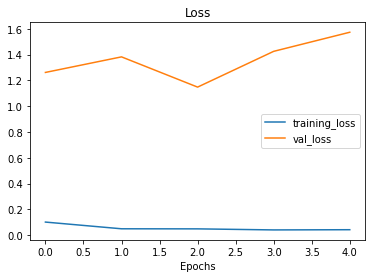

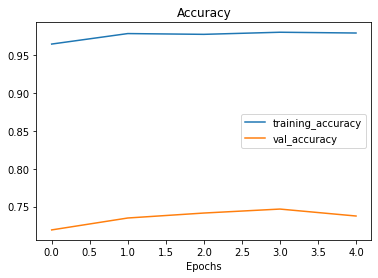

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(model_4_history)

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x widght)... however, our text data is 1D.

Previously we've used Conv2D for our image data but now we're going to user Conv1D

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D with some Pooling layer) -> outputs (class probabilities)
```

### Model 5: Conv1D

For differente explanations of parameters see:
* Cnn Explainer
* Difference between "same" and "valid" padding on Stack OverFlow

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into an embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="same")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most import feature or get the feature with the higher value
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape


(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=8, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="BinaryCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()


Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 8)             5128      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230130-195647
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.2428 - accuracy: 0.9229 - val_loss: 0.6722 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0990 - accuracy: 0.9666 - val_loss: 0.8359 - val_accuracy: 0.7388
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0727 - accuracy: 0.9756 - val_loss: 0.9770 - val_accuracy: 0.7388
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0602 - accuracy: 0.9772 - val_loss: 1.0588 - val_accuracy: 0.7428
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0543 - accuracy: 0.9787 - val_loss: 1.1245 - val_accuracy: 0.7415


In [ ]:
# Make some predictions with out Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[9.99616981e-01],
       [9.99892592e-01],
       [9.09434675e-05],
       [1.07429136e-04],
       [5.43445289e-01],
       [9.99992967e-01],
       [1.00000000e+00],
       [1.09102530e-03],
       [8.54231592e-04],
       [9.99999762e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 1., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels,
                                    model_5_preds)
model_5_results

{'accuracy': 74.1469816272966,
 'precision': 0.7426223267379216,
 'recall': 0.7414698162729659,
 'f1': 0.7418913679163275}

In [ ]:
baseline_results

{'accuracy': 79.79002624671917,
 'precision': 0.8049118114708822,
 'recall': 0.7979002624671916,
 'f1': 0.7932923017133588}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP.

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the unversal sentence encoder on a sentence, it turns it into a sequence of numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype="string",
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="BinaryCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230130-195732
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5040 - accuracy: 0.7827 - val_loss: 0.4458 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4148 - accuracy: 0.8145 - val_loss: 0.4327 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4020 - accuracy: 0.8238 - val_loss: 0.4329 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3930 - accuracy: 0.8298 - val_loss: 0.4305 - val_accuracy: 0.8018
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3863 - accuracy: 0.8286 - val_loss: 0.4305 - val_accuracy: 0.7992


In [ ]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 15ms/step


array([[0.83848155],
       [0.9204209 ],
       [0.1342739 ],
       [0.07740533],
       [0.25688386],
       [0.64215714],
       [0.987193  ],
       [0.08019008],
       [0.14612202],
       [0.98479974]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels,
                                    model_6_preds)
model_6_results

{'accuracy': 79.92125984251969,
 'precision': 0.7986655129353095,
 'recall': 0.7992125984251969,
 'f1': 0.7986243571898043}

In [ ]:
baseline_results

{'accuracy': 79.79002624671917,
 'precision': 0.8049118114708822,
 'recall': 0.7979002624671916,
 'f1': 0.7932923017133588}

In [ ]:
len(train_df_shuffled)

7613

## Model 7: TF Hub Pretrained USE but with 10% of trianing data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [ ]:
# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    394
1    291
dtype: int64

In [ ]:
# # Check the number of targets in our subset of data
# train_10_percent["target"].value_counts()

In [ ]:
# Build the model
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_7.compile(loss="BinaryCrossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Fit
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])                                                                     


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230130-195752
Epoch 1/5
22/22 [==============================] - 3s 50ms/step - loss: 0.6633 - accuracy: 0.7270 - val_loss: 0.6331 - val_accuracy: 0.7467
Epoch 2/5
22/22 [==============================] - 1s 42ms/step - loss: 0.5888 - accuracy: 0.8263 - val_loss: 0.5705 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 1s 48ms/step - loss: 0.5119 - accuracy: 0.8438 - val_loss: 0.5129 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 52ms/step - loss: 0.4495 - accuracy: 0.8409 - val_loss: 0.4839 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 1s 34ms/step - loss: 0.4101 - accuracy: 0.8496 - val_loss: 0.4707 - val_accuracy: 0.7769


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 12ms/step


array([[0.82205075],
       [0.75549334],
       [0.543603  ],
       [0.07686915],
       [0.32365224],
       [0.6882143 ],
       [0.9192167 ],
       [0.31809315],
       [0.16873008],
       [0.92459714]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Evaluate model 7 predictions
model_7_results = calculate_results(val_labels,
                                    model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7776230762999208,
 'recall': 0.7769028871391076,
 'f1': 0.7771770368466552}

In [ ]:
model_6_results

{'accuracy': 79.92125984251969,
 'precision': 0.7986655129353095,
 'recall': 0.7992125984251969,
 'f1': 0.7986243571898043}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

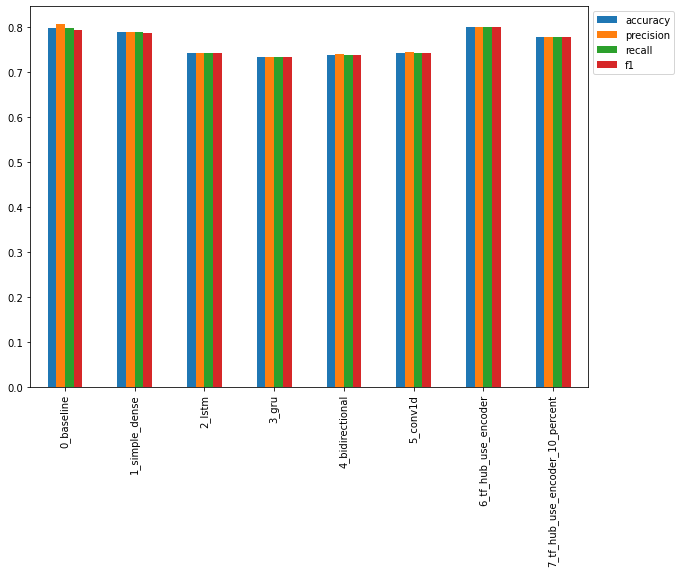

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

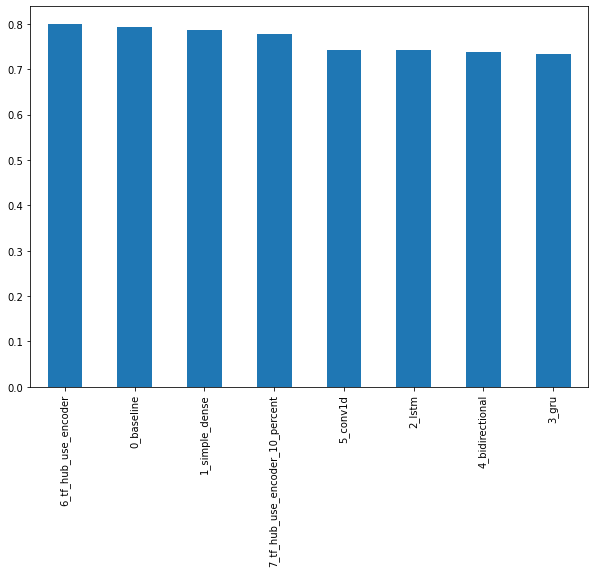

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to Tensorboard.dev

In [ ]:
 # View TensorBoard logs of transfer learning modelling experiments (pluss all of our other models)
 # Upload TensorBoard dev records
 !tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modeliing Experiments ZTM TF Course Video" \
  --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


Now I've ran the cell above, my modelling experiments are visable on TensorBoard.dev: https://tensorboard.dev/experiment/Xgj0DI8qSZOQxEjXGqopOg/#scalars

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using Tensorflow)


In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format 
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4305 - accuracy: 0.7992


[0.43051207065582275, 0.7992125749588013]

In [ ]:
model_6_results["accuracy"]/100

0.7992125984251969

Now let's save to the `SavedModel` format...

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format
model_6.save("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedFormat = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedFormat.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4305 - accuracy: 0.7992


[0.43051207065582275, 0.7992125749588013]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of thesse wrong examples which ones is it gettint *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a samples whould have a label of 0 but our model predicts a prediction probability of 0.999 and vice-versa.

In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-01-30 20:02:15--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  33.0MB/s    in 29s     

2023-01-30 20:02:45 (31.8 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.3872 - accuracy: 0.8241


[0.38718464970588684, 0.8241469860076904]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 0., 0., 0., 1., 1., 0., 0., 1.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text":val_sentences,
                       "target":val_labels,
                       "pred":model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,#IDFire Cherokee Road and Road 22 (Three Siste...,1,1.0,0.844321
1,Beautiful lightning as seen from plane window ...,0,1.0,0.851977
2,Why did God order obliteration of ancient Cana...,0,0.0,0.114461
3,@Caitsroberts see U the night wee bArra to get...,0,0.0,0.063718
4,Pandemonium In Aba As Woman Delivers Baby With...,1,0.0,0.247876


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
print(most_wrong[:1]["text"]) # False positives

287    @TwopTwips make natural disaster reporting mor...
Name: text, dtype: object


Let's remind ourselves of the target labels...
* `0` = not disaster
* 1 = disaster

In [ ]:
most_wrong.tail() # False negatives

,text,target,pred,pred_prob
620,Ain't no hoe in my blood,1,0.0,0.076207
616,you can stab me in the back but I promise you'...,1,0.0,0.055746
673,@leedsrouge Love what you picked! We're playin...,1,0.0,0.053190
216,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
714,Oh the usual. Mass murder and world domination...,1,0.0,0.036498


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred:{pred}, Prob:{pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

In [ ]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, Pred:{pred}, Prob:{pred_prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

## Making predictions on the test dataset

In [ ]:
# Making prediction on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_sentences[:5]
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob:{pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("-----\n")

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob:0.5127962827682495
Text:
@5SOSFamUpdater social casualty

-----

1/1 [==============================] - 0s 32ms/step
Pred: 0, Prob:0.0383123978972435
Text:
@RobynJilllian @WlSDOMTEETHS I feel like I'm going to do it on accident. Teesha is gonna come out??

-----

1/1 [==============================] - 0s 31ms/step
Pred: 1, Prob:0.9220028519630432
Text:
Grass fire burns past Roosevelt Wash. prompts evacuation http://t.co/BSuDXCPrSG #fire #firefighter

-----

1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob:0.21760234236717224
Text:
@KnaveTBE lol. Not the class but the class of weapon

-----

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob:0.09979484975337982
Text:
@globepolitics extreme positions lack of debate pandering to the hard-right - further increase divides corrodes trust and damage goodwill

-----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob:0.1702200025320

## Your challenge... predicting on Tweets from the wild

Got to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.
Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained,
                                                            val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 20ms/step


(0.7092036070000631, 0.0009307133950132062)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.0651423159999922, 8.548860367453045e-05)

In [ ]:
# Get results for ptreained GS model
model_6_pretrained_results = calculate_results(val_labels,
                                               model_6_pretrained_preds)

Text(0, 0.5, 'F1-Score')

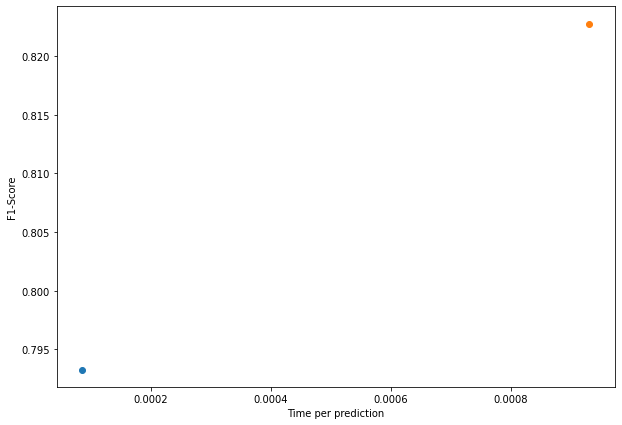

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")